<a href="https://colab.research.google.com/github/Zrmikstri/CS114.M21.KHCL.N07/blob/main/Yolov5/Training_Evaluating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Truy cập https://drive.google.com/drive/folders/1l_kbP5UgGfaZ0SCrVXsTtc52yGmUlrjh?usp=sharing  
Tạo lối tắt cho thư mục vừa truy cập vào trong My Drive (Drive của tôi).

Bước 1: Tạo lối tắt

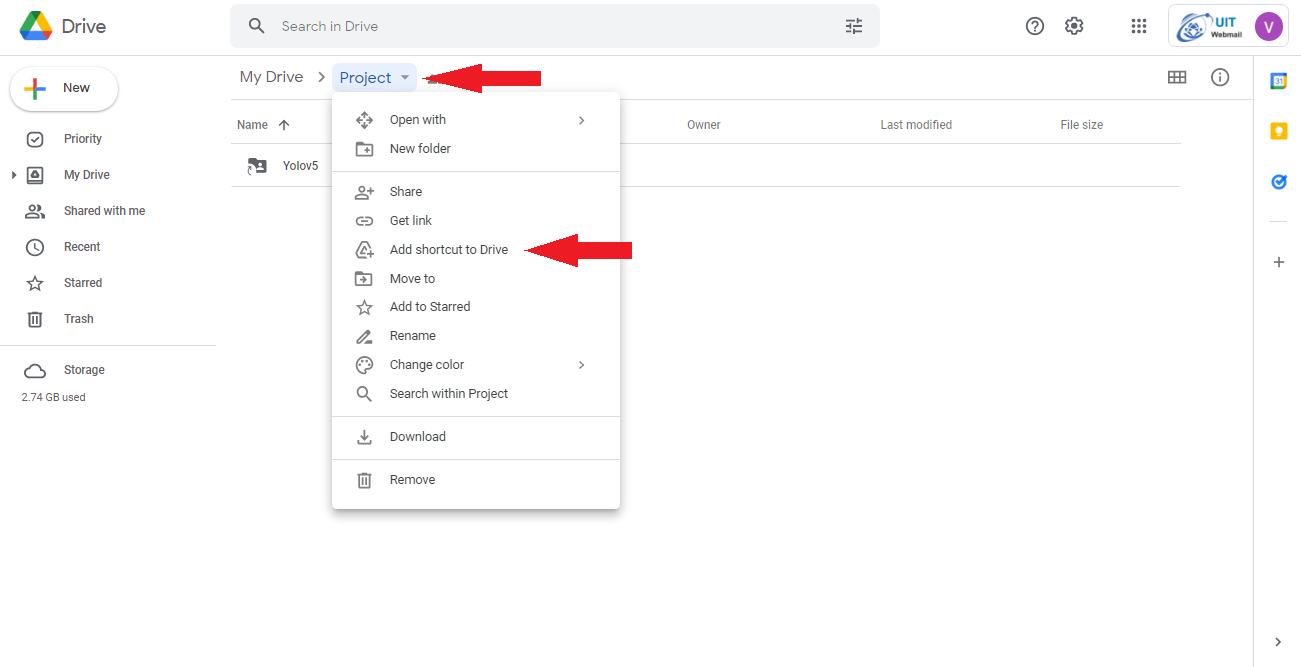
Bước 2: Chọn My Drive (Drive của tôi) và chọn Add Shortcut (Thêm lối tắt)
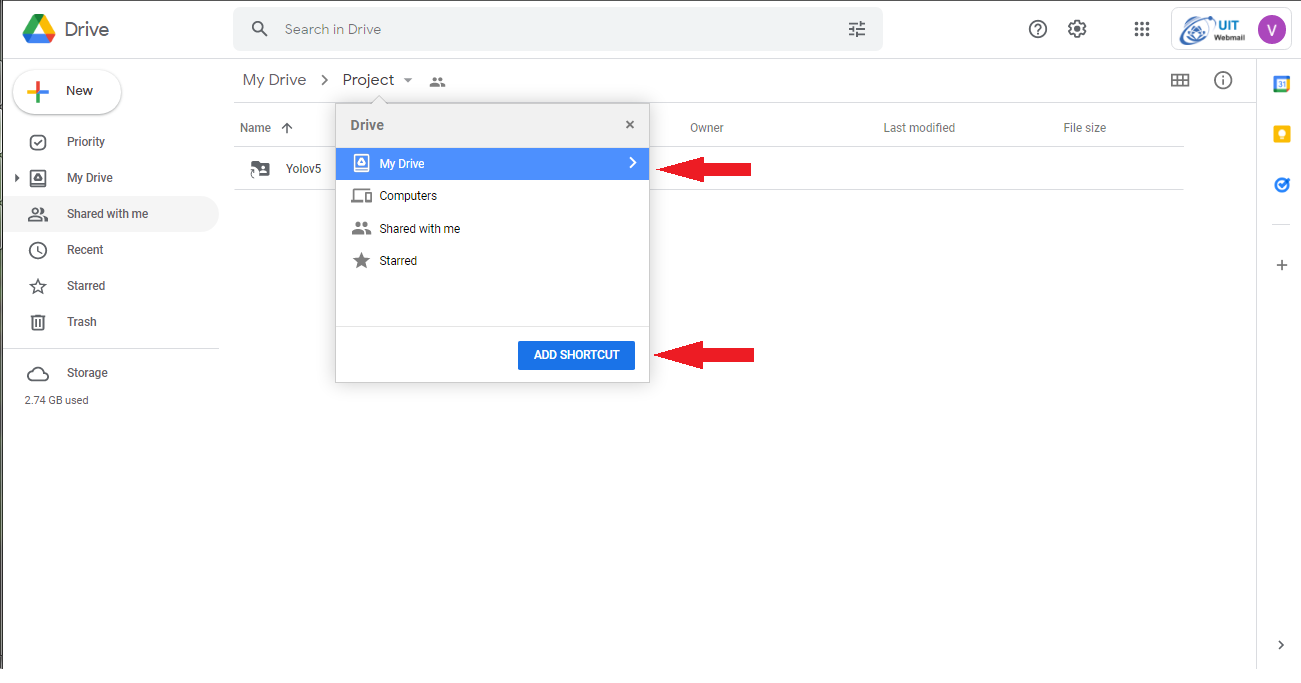

Tiếp đến vào Runtime -> Change Runtime type -> Chọn GPU -> Save

Để chạy một cell chứa code, chỉ cần di chuyển chuột đến cell đó và chọn nút tam giác hiện ở đầu bên trái mỗi cell.  

# HƯỚNG DẪN CHẠY NOTEBOOK

1. Chạy hết các cellcode trong step 1 và 2 bằng cách ấn trỏ chuột vào từng ô chứa code và ấn CTRL + ENTER

2. Nếu chỉ cần xem các kết quả của nhóm chạy được thì không cần phải chạy cell nào. Chỉ cần coi ô output của từng cell là được.

3. Nếu training thì xem tiếp các hướng dẫn trong step 3.

4. Nếu muốn đánh giá model có sẵn hoặc model vừa train xong ở step 3 thì xem tiếp hướng dẫn trong step 4

5. Nếu chỉ muốn sử dụng model thì bỏ qua step 3 và 4, và xem hướng dẫn ở step 5.

6. Các kết quả do mô hình chạy được sẽ được lưu tại đường dẫn mô hình xuất ra ở cuối mỗi cel.
Thông báo đường dẫn mô hình lưu kết quả có dạng `Results saved to runs/` +:

*   `detect`: nếu sử dụng mô hình ở bước 5 (run inference)
*   `val`: nếu sử dụng mô hình ở bước 4 (evaluating)
*   `train`: nếu sử dụng mô hình ở bước 3 (train)

Mỗi lần chạy mô hình sẽ lưu tiếp vào một thư mục `exp` kèm theo số thứ tự trong 3 thư mục trên.






# Step 1: Install Requirements

Cài đặt các thư viện cần thiết cũng như clone repo Yolov5 mà nhóm em đã chỉnh sửa từ repo gốc (https://github.com/ultralytics/yolov5) để hỗ trợ cho việc che biển số.

Chạy hết 3 cell trong mục này.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Zrmikstri/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

Cloning into 'yolov5'...
remote: Enumerating objects: 12355, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12355 (delta 1), reused 3 (delta 0), pack-reused 12350
Receiving objects: 100% (12355/12355), 12.62 MiB | 13.50 MiB/s, done.
Resolving deltas: 100% (8520/8520), done.
/content/yolov5
     |████████████████████████████████| 596 kB 28.1 MB/s 
     |████████████████████████████████| 145 kB 43.0 MB/s 
     |████████████████████████████████| 178 kB 66.9 MB/s 
     |████████████████████████████████| 3.1 MB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 18.9 MB/s 
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 138 kB 67.8 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account a

In [3]:
import os
import cv2
import imutils
import torch
import glob

from google.colab.patches import cv2_imshow
from IPython.display import Image, display, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


# Step 2: Download Our Dataset

* Tải tập dataset mà nhóm dùng để huấn luyện mô hình và đánh giá mô hình. 
* Dataset được nhóm gán nhãn sử dụng Roboflow (https://app.roboflow.com/)
* Chạy hết 4 cell trong mục này.


In [4]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [5]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [6]:
rf = Roboflow(api_key="76VMxCseoOoXLvJ1qeCi")
project = rf.workspace("license-plate-x8kza").project("license_plate-c6jin")
dataset = project.version(4).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/license_plate-4 in yolov5pytorch:: 100%|██████████| 6834/6834 [00:07<00:00, 925.31it/s] 


In [7]:
with open('/content/datasets/license_plate-4/data.yaml','a+') as yamlfile:
        yamlfile.write('\ntest: /content/datasets/license_plate-4/test/images')

# Step 3: Train Our Custom YOLOv5 model

Trước khi train, ta cần truyền vào một số tham số có file **train.py**:
- **img:** kích thước ảnh đầu vào. Mặc đinh 640
- **batch-size:** số lượng mỗi ảnh của từng batch để mô hình xử lý. Truyền -1 để mô hình tự tính toán kích thước của batch. Mặc định 32
- **epochs:** số epoch để train mô hình. (Thường >= 3000). Mặc định là 300.
- **data:** đường dẫn của dataset được lưu tại `dataset.location`
- **weights:** sử dụng weight được train sẵn để tiến hành transfer learning. Nhóm chọn sử dụng yolov5l.pt
- **cache:** cache hình ảnh để training diễn ra nhanh hơn
- **patience:** số lượng epoch mà kết quả của mô hình không cải thiện trước khi dừng. Mặc đinh 100 epoch
- **project:** đường dẫn của thư mục project, nơi mà mô hình sẽ lưu các thư mục chạy thử nghiệm
- **name:** tên thư mục chạy thử nghiệm, lưu trữ kết quả training, evaluation 

Ngoài ra, mô hình còn nhận thêm các tham số khác. Mô hình sẽ sử dụng các giá trị mặc định của tham số nếu tham số để trống. Tham khảo thêm tại soucre code của Ultralytic https://github.com/ultralytics/yolov5.

## Training

Để bắt đầu Training, ta sẽ chạy cell dưới dây. Nhóm chọn weight yolov5l.pt đã được pretrain để bắt đầu transfer learning.

In [ ]:
%rm -r /content/drive/MyDrive/Project/Yolov5/Run_7July_1_label

In [ ]:
!python train.py --weights yolov5l.pt --img 640 --batch-size -1 --epochs 1000 --data {dataset.location}/data.yaml  --cache 

Do Colab miễn phí nên thời gian train mô hình có hạn. Do đó, Ultralytic hỗ trợ checkpoint. Nghĩa là mô hình sẽ lưu weight có kết quả tốt nhất dưới tên **best.pt** và weight của epoch cuối cùng trước khi tạm dừng training dưới tên **last.pt**.

Để tiếp tục phần train tạm dừng trước đó, ta sẽ chạy file **train.py** chỉ truyền vào tham số **resume** đường dẫn tới file **last.pt**. Mô hình sẽ tự động train tiếp đến khi tới giới hạn thời gian của Colab hoặc tới khi hết số epoch được xác định ở lần train đầu tiên. 

Lưu ý: khi tiếp tục train, chỉ truyền duy nhất tham số **--resume** và đường dẫn tới **last.pt**. Không được truyền các tham số khác.

In [ ]:
!python train.py --resume /path/to/last.pt

## Kết quả training của nhóm

Không nên chạy để tránh mất kết quả

In [ ]:
!python train.py --weights yolov5l.pt --img 640 --batch-size -1 --epochs 1000 --data {dataset.location}/data.yaml  --cache --project "/content/drive/MyDrive/Project/Yolov5" --name Run_7July_1_label

train: weights=yolov5l.pt, cfg=, data=/content/datasets/license_plate-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1000, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/Project/Yolov5, name=Run_7July_1_label, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/Zrmikstri/yolov5 ✅
YOLOv5 🚀 v6.1-266-ged95502 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

# Step 4: Evaluate our model

Để dánh giá, ta sẽ chạy hàm **val.py** và có thể truyền các tham số sau:
- **data:** đường dẫn của dataset được lưu tại `dataset.location`
- **weights:** đường dẫn tới best.pt sau khi train xong mô hình.
- **batch-size:** số lượng mỗi ảnh của từng batch để mô hình xử lý. Truyền -1 để mô hình tự tính toán kích thước của batch. Mặc định 32.
- **img:** kích thước ảnh đầu vào. Mặc đinh 640
- **task:** loại công việc thực hiện gồm: val (đánh giá trên tập validation), test (đánh giá trên tập test), speed (đánh giá tốc độ của mô hình), study (phân tích mô hình)
- **single-cls:** coi dataset như dataset chỉ có một lớp
- **save-txt:** lưu kết quả phát hiện vị trí biển số thành file txt
- **save-hybrid:** lưu kết quả phát hiện vị trí biển số và vị trí ground truth
- **project:** đường dẫn của thư mục project, nơi mà mô hình sẽ lưu các thư mục chạy thử nghiệm
- **name:** tên thư mục chạy thử nghiệm, lưu trữ kết quả training, evaluation 

Ngoài ra, mô hình còn nhận thêm các tham số khác. Mô hình sẽ sử dụng các giá trị mặc định của tham số nếu tham số để trống. Tham khảo thêm tại soucre code của Ultralytic https://github.com/ultralytics/yolov5.



## Đánh giá trên tập validation



### Chạy đánh giá trên tập validation

In [13]:
!python val.py --weights /content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt --data {dataset.location}/data.yaml --task val --iou-thres 0.5

val: data=/content/datasets/license_plate-4/data.yaml, weights=['/content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-268-gecc2bde Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
val: Scanning '/content/datasets/license_plate-4/valid/labels.cache' images and labels... 679 found, 0 missing, 0 empty, 0 corrupt: 100% 679/679 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5    mAP@.75 mAP@.5:.95: 100% 22/22 [00:23<00:00,  1.06s/it]
                 all        679        868      0.877      0.929       0.96      0.549      0.545
Speed: 0.3

### Kết quả đánh giá trên tập validation

P_CURVE.PNG


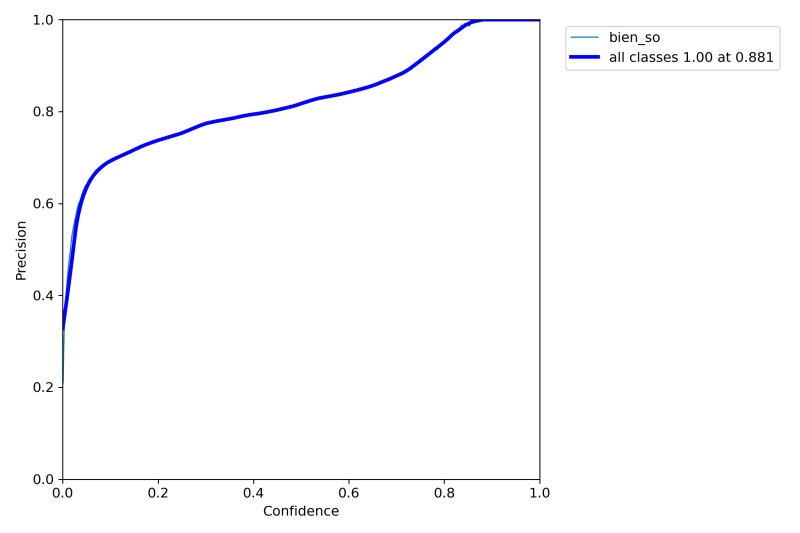





R_CURVE.PNG


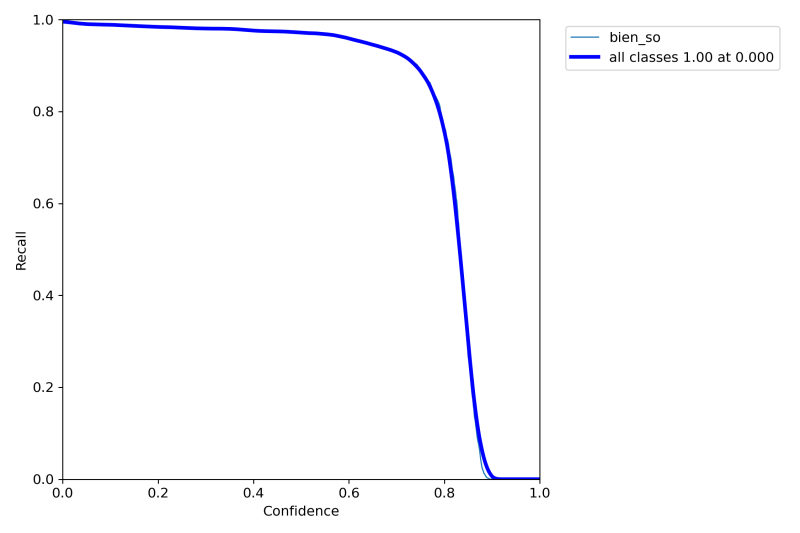





CONFUSION_MATRIX.PNG


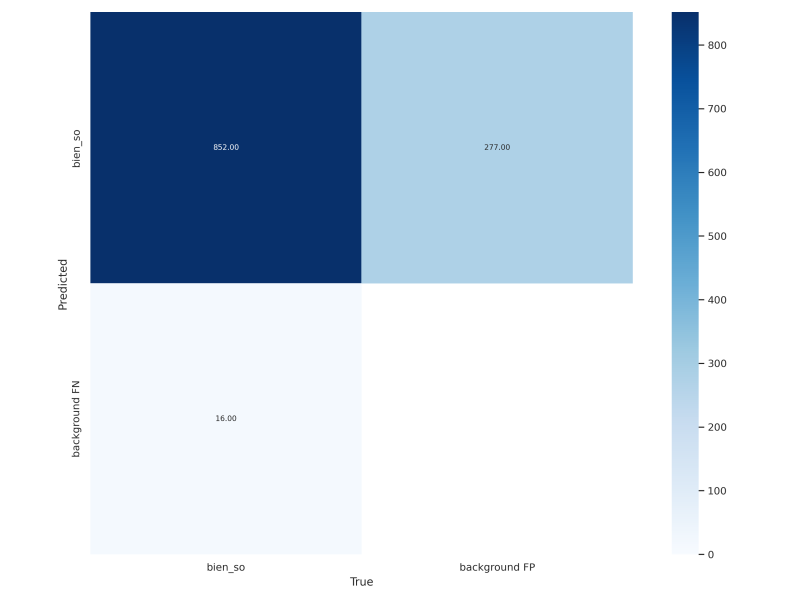





F1_CURVE.PNG


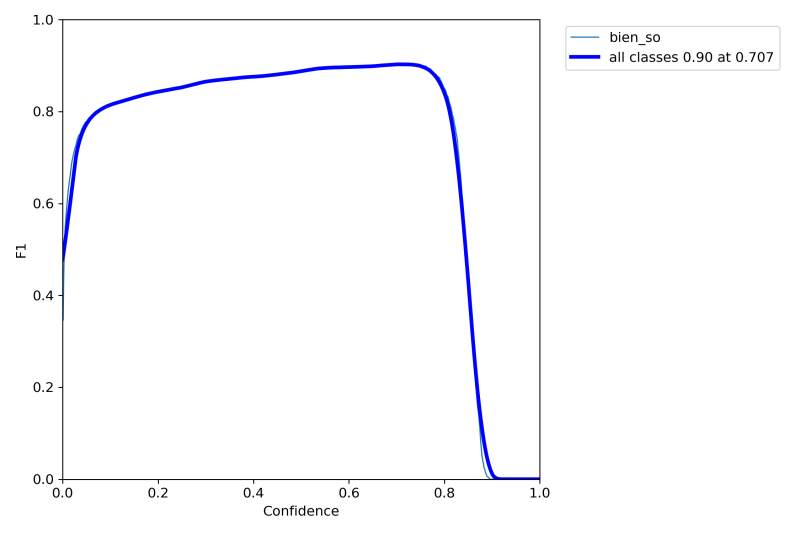





PR_CURVE.PNG


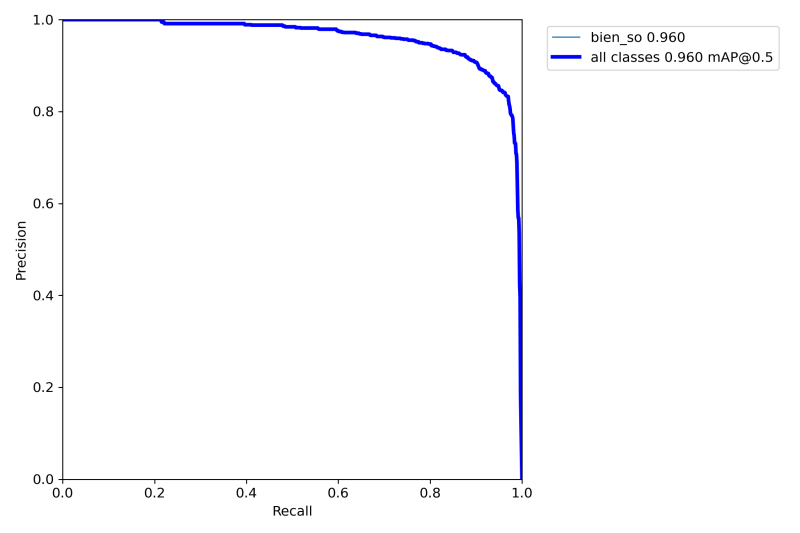

In [14]:
for imageName in glob.glob('/content/yolov5/runs/val/exp/*.png'):
    print(os.path.basename(imageName).upper())
    img = cv2.imread(imageName)
    img = imutils.resize(img, width=800)
    cv2_imshow(img)
    print('\n\n\n')

## Đánh giá trên tập test

### Chạy đánh giá trên tập test

In [15]:
!python val.py --weights /content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt --data {dataset.location}/data.yaml --task test --iou-thres 0.5

val: data=/content/datasets/license_plate-4/data.yaml, weights=['/content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-268-gecc2bde Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
test: Scanning '/content/datasets/license_plate-4/test/labels.cache' images and labels... 347 found, 0 missing, 0 empty, 0 corrupt: 100% 347/347 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5    mAP@.75 mAP@.5:.95: 100% 11/11 [00:13<00:00,  1.25s/it]
                 all        347        436      0.874      0.911      0.944      0.589      0.543
Speed: 0.

### Kết quả đánh giá trên tập test

P_CURVE.PNG


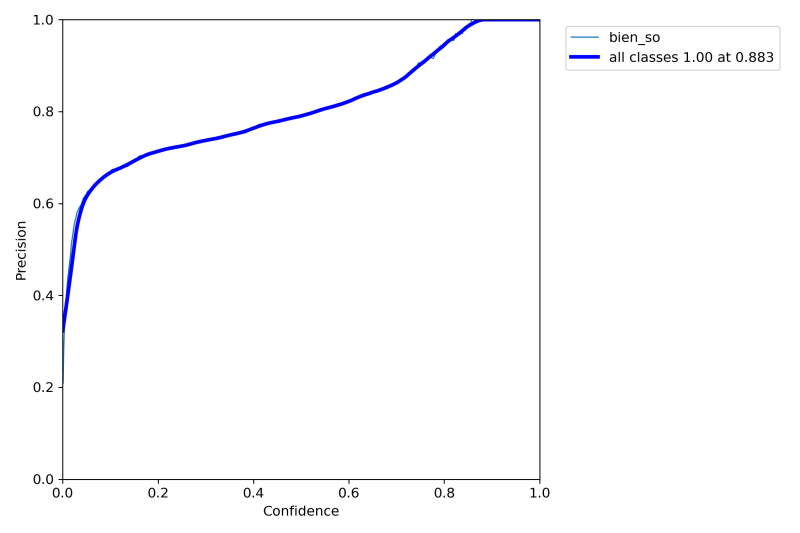





R_CURVE.PNG


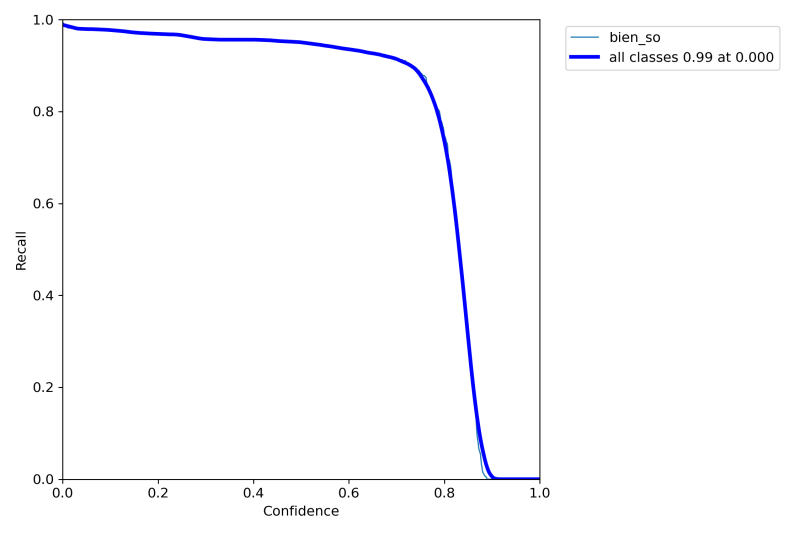





CONFUSION_MATRIX.PNG


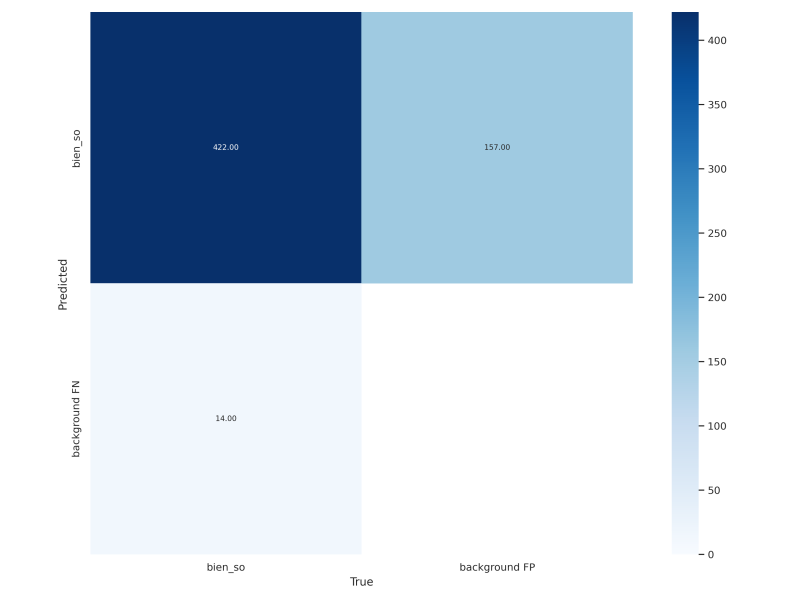





F1_CURVE.PNG






PR_CURVE.PNG


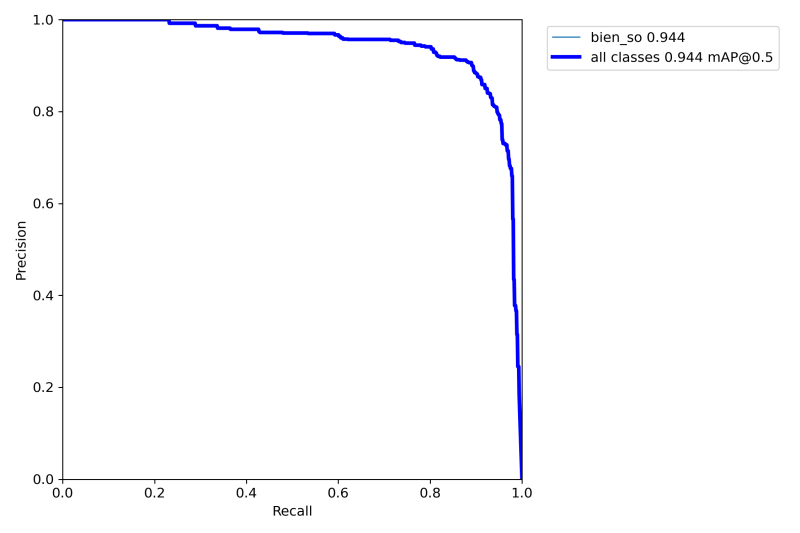

In [16]:
for imageName in glob.glob('runs/val/exp2/*.png'):
    print(os.path.basename(imageName).upper())
    img = cv2.imread(imageName)
    img = imutils.resize(img, width=800)
    cv2_imshow(img)
    print('\n\n\n')

# Step 5: Run Inference  With Trained Weights
Nếu muốn làm mờ biển số trên video, chỉ cần truyền tham số **censor** và **source** cùng đường dẫn tới video muốn làm mờ.

Vị trí lưu kết quả được mô hình thông báo phía cuối output của cell.

```shell
python detect.py --censor --source 0  # webcam
                                   img.jpg  # image 
                                   vid.mp4  # video
                                   path/  # directory
                                   path/*.jpg  # glob
                                   'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                                   'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

In [40]:
%rm -r /content/yolov5/runs/detect

In [41]:
!python detect.py --weights /content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt --img 640 --source /content/IMG20220611173813.jpg
img = cv2.imread('/content/yolov5/runs/detect/exp/IMG20220611173813.jpg')
img = imutils.resize(img, width=1500)
cv2_imshow(img)

detect: weights=['/content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt'], source=/content/IMG20220611173813.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, censor=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-268-gecc2bde Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/1 /content/IMG20220611173813.jpg: 480x640 3 bien_sos, Done. (0.045s)
Speed: 0.7ms pre-process, 45.3ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [42]:
!python detect.py --weights /content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt --censor --img 640 --source /content/IMG20220611173813.jpg
img = cv2.imread('/content/yolov5/runs/detect/exp2/IMG20220611173813.jpg')
img = imutils.resize(img, width=1500)
cv2_imshow(img)

detect: weights=['/content/drive/MyDrive/Yolov5_censor_license_plate_config/1_label_best.pt'], source=/content/IMG20220611173813.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, censor=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-268-gecc2bde Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/1 /content/IMG20220611173813.jpg: 480x640 3 bien_sos, Done. (0.045s)
Speed: 0.6ms pre-process, 45.3ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2
